In [67]:
import itertools
import os

import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from IPython.display import HTML, Markdown, display

MEASUREMENTS_FOLDER = "Variance logs"

setting_names = set(
    [
        "texture size",
        "downscale",
        "number of clusters",
        "number of iterations",
        "random swap",
        "randomize empty clusters",
        "KHM",
        "staggered jitter",
        "jitter size",
        "video file",
    ]
)

def load_measurements(measurement_name: str):
    log_file_names = os.listdir(f"{MEASUREMENTS_FOLDER}/{measurement_name}")
    
    def setting_transform(value):
        match value:
            case "True":
                return "Yes"
            case "False":
                return "No"
        return value

    def test(x):
        print(x)
        return x
    
    measurements = [
        {
            "settings" : {
                setting_name : setting_transform(setting_value)
                    for setting_name, setting_value in [
                            setting_text.split(':')
                                for setting_text in file_name.split('.')[0].split("|")
                        ]
            },
            "variance" : pd.read_csv(
                f"{MEASUREMENTS_FOLDER}/{measurement_name}/{file_name}"
            )["Variance"].tolist()[10:-10], # first and lust 10 frames removed
            "file name" : file_name
        }
        for file_name in log_file_names
    ]
    
    for measurement in measurements:
        assert (
            set(
                measurement["settings"].keys()
            ) == set(
                setting_names
            )
        )
    
    for measurement in measurements:
        measurement["total variance"] = sum(measurement["variance"]) / len(measurement["variance"])
    
    for measurement in measurements:
        measurement["peak variance"] = max(measurement["variance"])
    
    return measurements

def show_measurements_table(measurements):    
    def get_setting_value_lengths(measurements):
        return {
            setting_name : max(
                max(
                    [
                        len(measurement['settings'][setting_name])
                            for measurement in measurements
                    ]
                ),
                len(setting_name)
            )
            for setting_name in setting_names
        }
    
    def get_settings_same_everywhere(measurements):
        def is_setting_same_everywhere(setting_name):
            for measurement in measurements:
                if measurement["settings"][setting_name] != measurements[0]["settings"][setting_name]:
                    return False
            return True
        return [setting_name for setting_name in setting_names if is_setting_same_everywhere(setting_name)]
    
    setting_value_lengths = get_setting_value_lengths(measurements)
    settings_same_everywhere = get_settings_same_everywhere(measurements)
    
    def print_setting(name, value):
        print(value, end="")
        print(
            " " * (
                setting_value_lengths[name] - len(value)
            ),
            end=""
        )


    for setting_name in setting_names:
        if setting_name in settings_same_everywhere:
            continue
        print(setting_name, end="")
        print("  |  ", end="")
    print("variance")
    print("-" *
        (
            sum(
                [
                    setting_value_lengths[name] + 5
                    for name in setting_names
                    if not name in settings_same_everywhere
                ]
            ) + 8
        )
    )

    for measurement in measurements:
        for setting_name in setting_names:
            if setting_name in settings_same_everywhere:
                continue
            print_setting(setting_name, measurement['settings'][setting_name])
            print("  |  ", end="")
        total_variance_string = f"{measurement['total variance']:0.5f}"
        print(f'{total_variance_string:10}', end="")
        print()

In [2]:
def plot_diff(index1, index2):    
    diff = [
        a - b for a,b in zip(
            logs[index1]["variance"],
            logs[index2]["variance"]
        )
    ]
    
    _, ax = plt.subplots()
    
    sb.lineplot(
        x=logs[index1]["Frame"],
        y=diff,
        ax=ax,
        label=f"{names[index1]} -\n{names[index2]}"
    )    
    plt.ylabel("ΔVariance")
    
    plt.show() # display plots RIGHT NOW
    
def plot_log(indices, do_plot_diff = False):    
    _, ax = plt.subplots()
    
    for logIndex in indices:
        sb.lineplot(
            x=logs[logIndex]["Frame"],
            y=logs[logIndex]["variance"],
            ax=ax,
            label=names[logIndex]
        )
    
    if do_plot_diff:
        assert(len(indices) == 2)
        plot_diff(indices[0], indices[1])
    
    plt.show() # display plots RIGHT NOW

In [3]:
def init_seaborn():
    sb.set(
        font_scale=1.2,
        rc={
            "figure.figsize":(14, 6)
        },
        palette="deep"
    )

init_seaborn()

In [4]:
display(Markdown("# ToDo measurements"))

display(
    Markdown(
"""
|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.
"""
    )
)

# ToDo measurements


|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.


In [5]:
display(Markdown('# Dataset 1: subsampling'))

M1 = load_measurements("1. subsampling")

M1 = sorted(
    M1,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
    )
)


show_measurements_table(M1)

# Dataset 1: subsampling

texture size  |  video file  |  number of clusters  |  variance
---------------------------------------------------------------
512           |  1           |  4                   |  0.01443   
512           |  1           |  6                   |  0.00765   
512           |  1           |  8                   |  0.00496   
512           |  1           |  12                  |  0.00243   
512           |  1           |  16                  |  0.00151   
256           |  1           |  4                   |  0.01443   
256           |  1           |  6                   |  0.00766   
256           |  1           |  8                   |  0.00496   
256           |  1           |  12                  |  0.00244   
256           |  1           |  16                  |  0.00152   
128           |  1           |  4                   |  0.01443   
128           |  1           |  6                   |  0.00765   
128           |  1           |  8                   |  0.00497   
128           

## Plots

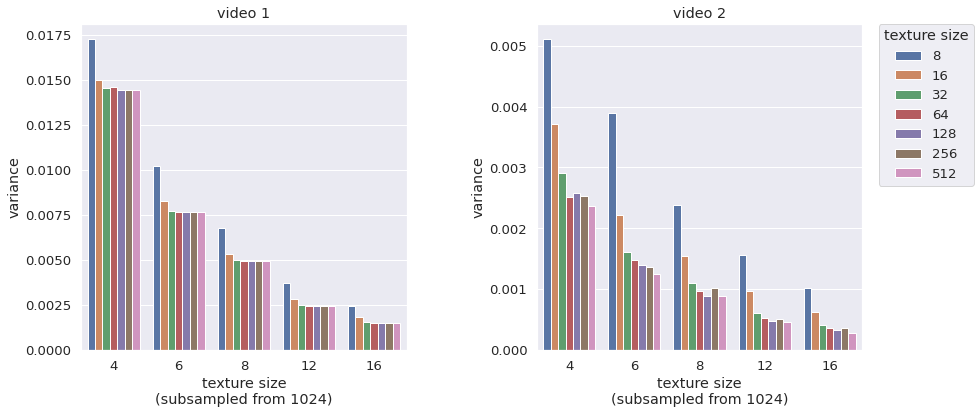

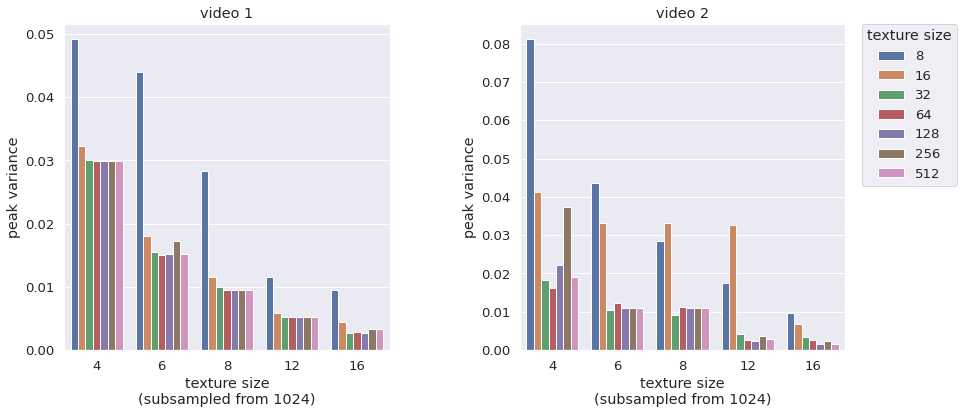

In [6]:
display(Markdown("## Plots"))

def subsample_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "number of clusters"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=total_variance_by_texture_size["video 1"]["number of clusters"],
        y=total_variance_by_texture_size["video 1"]["total variance"],
        ax=axes[0],
        hue=total_variance_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_variance_by_texture_size["video 2"]["number of clusters"],
        y=total_variance_by_texture_size["video 2"]["total variance"],
        ax=axes[1],
        hue=total_variance_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
def subsample_peak_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "number of clusters"]
        )



    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=data["video 1"]["number of clusters"],
        y=data["video 1"]["peak variance"],
        ax=axes[0],
        hue=data["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("peak variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=data["video 2"]["number of clusters"],
        y=data["video 2"]["peak variance"],
        ax=axes[1],
        hue=data["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("peak variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
subsample_variance_plots()
subsample_peak_variance_plots()

In [7]:
display(Markdown('# Dataset 2: scaling vs subsampling'))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

# Dataset 2: scaling vs subsampling

downscale  |  texture size  |  video file  |  variance
------------------------------------------------------
No         |  512           |  1           |  0.00765   
Yes        |  512           |  1           |  0.00765   
No         |  256           |  1           |  0.00766   
Yes        |  256           |  1           |  0.00773   
No         |  128           |  1           |  0.00765   
Yes        |  128           |  1           |  0.00765   
No         |  64            |  1           |  0.00764   
Yes        |  64            |  1           |  0.00766   
No         |  32            |  1           |  0.00772   
Yes        |  32            |  1           |  0.00783   
No         |  16            |  1           |  0.00827   
Yes        |  16            |  1           |  0.00809   
No         |  8             |  1           |  0.01019   
Yes        |  8             |  1           |  0.00966   
No         |  512           |  2           |  0.00125   
Yes        |  512           |  2   

## Plots

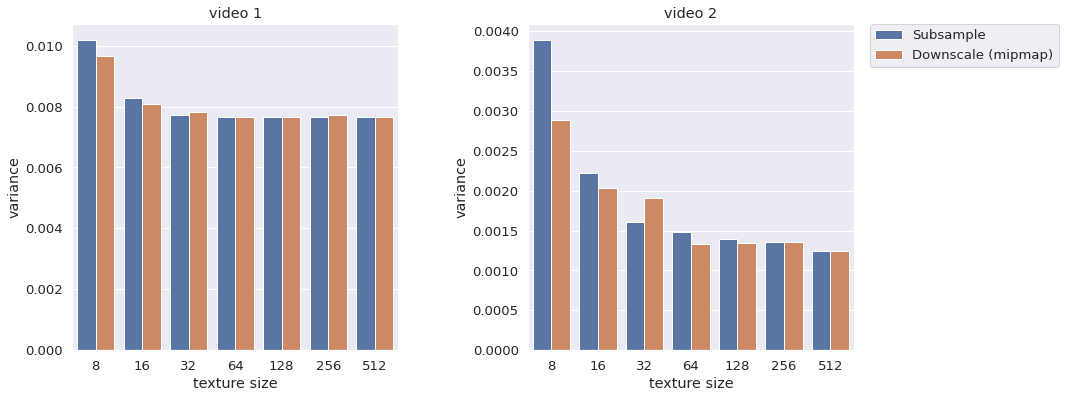

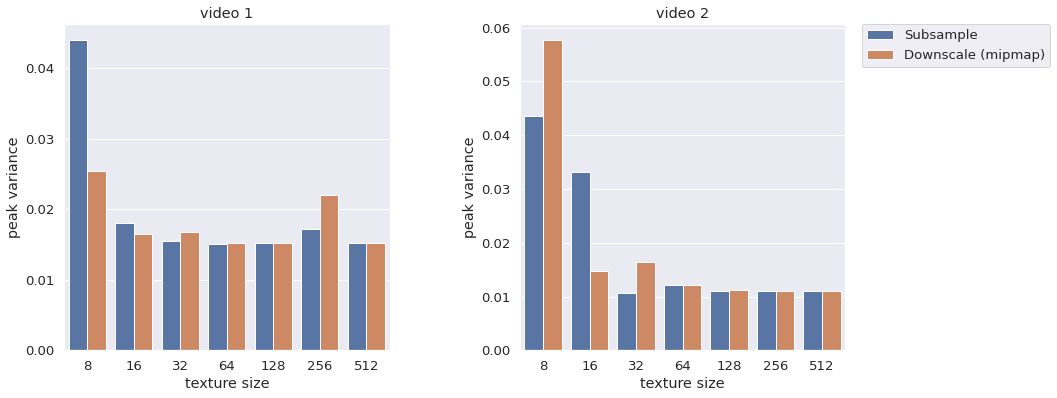

In [8]:
display(Markdown("## Plots"))

def subsample_vs_downscale_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['texture size']),
                    
                    "Downscale (mipmap)"
                            if measurement['settings']['downscale'] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["total variance", "peak variance", "texture size", "downscale"]
        )

    data_frames = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
        )
        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
        )
        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    plot_variance()
    plot_peak_variance()

subsample_vs_downscale_plots()

In [9]:
display(Markdown('## Jitter'))

## Jitter

In [10]:
display(Markdown('## Dataset 3: staggered jitter'))

M3 = load_measurements("3. staggered jitter")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)


show_measurements_table(M3)

## Dataset 3: staggered jitter

texture size  |  jitter size  |  video file  |  variance
--------------------------------------------------------
64            |  1            |  1           |  0.00764   
32            |  1            |  1           |  0.00772   
32            |  2            |  1           |  0.00774   
16            |  1            |  1           |  0.00827   
16            |  2            |  1           |  0.00832   
16            |  4            |  1           |  0.00812   
8             |  1            |  1           |  0.01019   
8             |  2            |  1           |  0.01012   
8             |  4            |  1           |  0.00982   
8             |  8            |  1           |  0.00970   
4             |  1            |  1           |  0.01538   
4             |  16           |  1           |  0.01450   
4             |  2            |  1           |  0.01513   
4             |  4            |  1           |  0.01496   
4             |  8            |  1           |  0.01500   
6

In [11]:
display(Markdown('## Dataset 4: scanline jitter'))

M4 = load_measurements("4. scanline jitter")

M4 = sorted(
    M4,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)

show_measurements_table(M4)

## Dataset 4: scanline jitter

texture size  |  jitter size  |  video file  |  variance
--------------------------------------------------------
64            |  1            |  1           |  0.00764   
32            |  1            |  1           |  0.00772   
32            |  2            |  1           |  0.00772   
16            |  1            |  1           |  0.00827   
16            |  2            |  1           |  0.00814   
16            |  4            |  1           |  0.00815   
8             |  1            |  1           |  0.01019   
8             |  2            |  1           |  0.01004   
8             |  4            |  1           |  0.00994   
8             |  8            |  1           |  0.01005   
4             |  1            |  1           |  0.01538   
4             |  16           |  1           |  0.01518   
4             |  2            |  1           |  0.01507   
4             |  4            |  1           |  0.01554   
4             |  8            |  1           |  0.01532   
6

### Plots

#### Staggered jitter

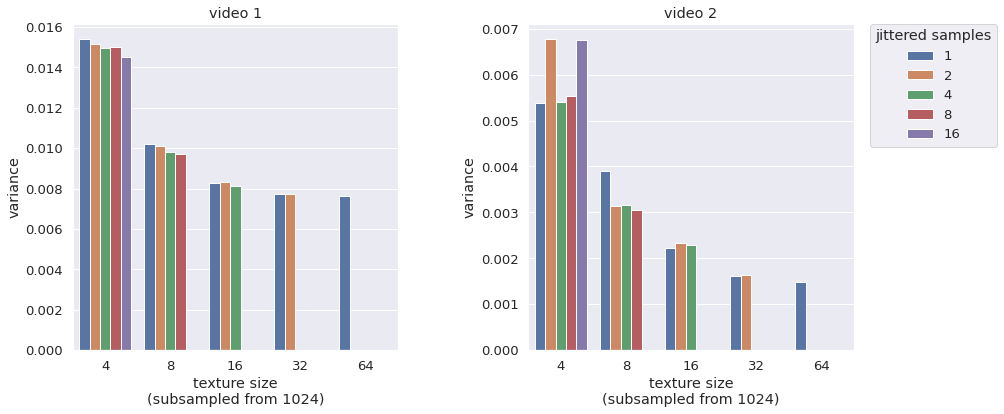

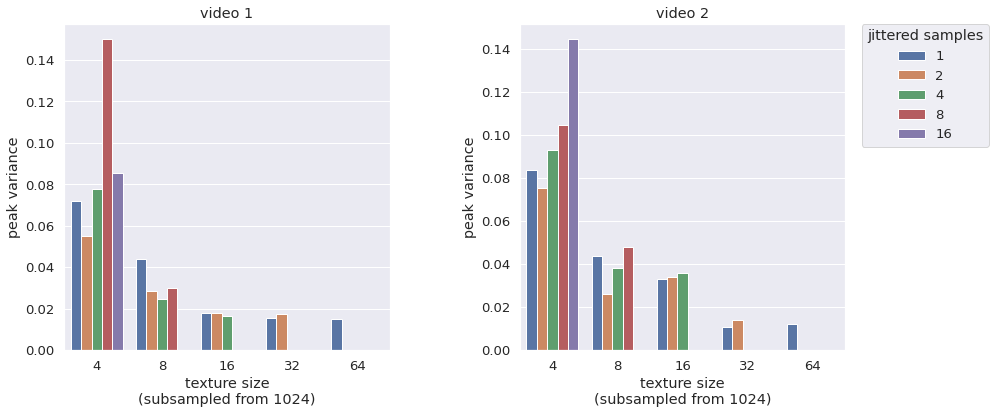

#### Scanline jitter

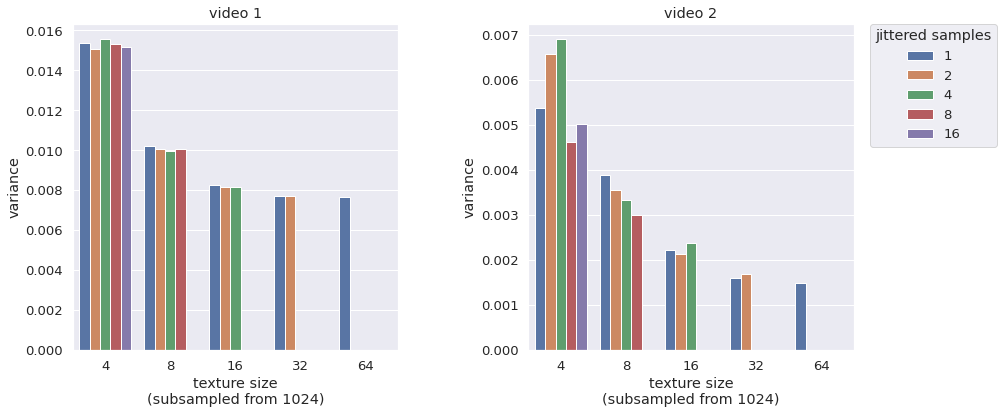

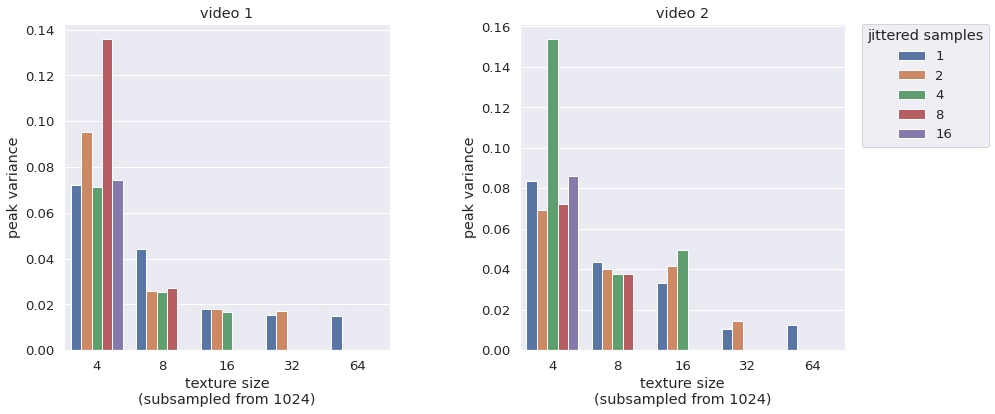

#### Difference

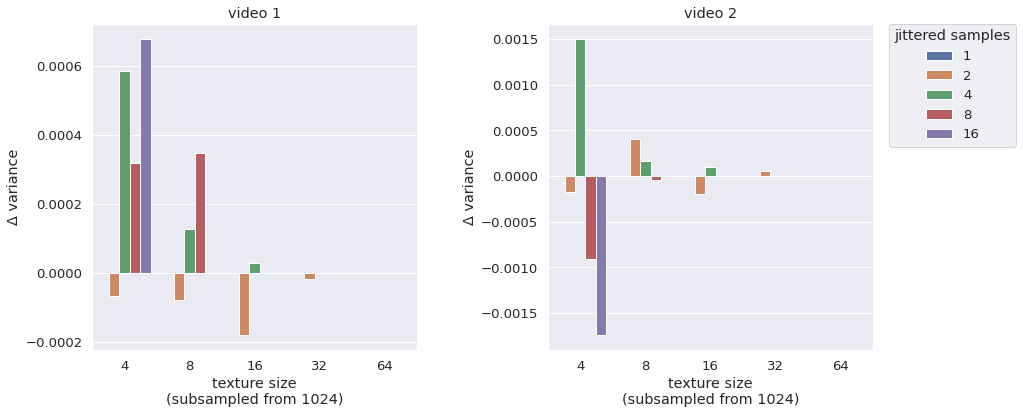

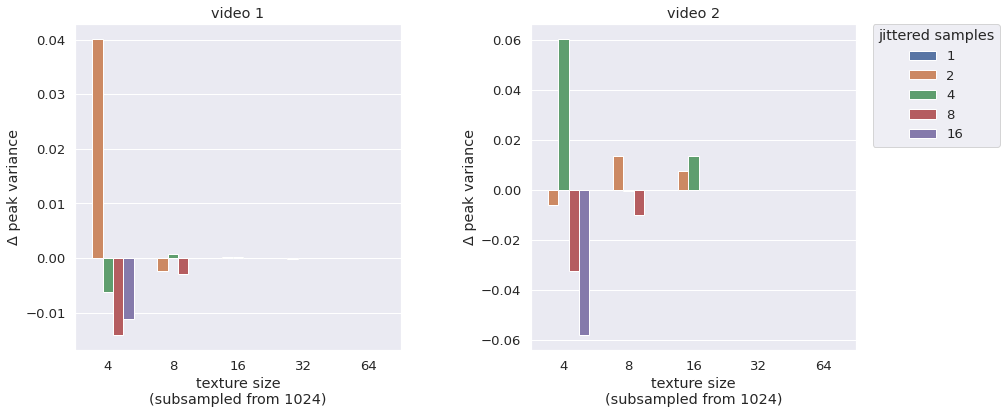


Positive numbers mean variance is greater with scanline jitter.
            

In [12]:
display(Markdown("### Plots"))

def jitter_plots():
    
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['jitter size'])
                )
                    for measurement in measurements
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "jitter size"]
        )
    
    def load_video_delta(video_name):
        return pd.DataFrame(
            [
                (
                    int(M4[i]['settings']['texture size']),
                    M4[i]['total variance'] - M3[i]['total variance'],
                    M4[i]['peak variance'] - M3[i]['peak variance'],
                    int(M4[i]['settings']['jitter size'])
                )
                    for i in range(len(M4))
                        if M4[i]['settings']["video file"] == video_name
            ],
            columns=["texture size", "delta variance", "delta peak variance", "jitter size"]
        )


    data_frames_staggered_jitter = {
        f"video {video}" : load_video(video, M3)
            for video in ["1", "2"]
    }
    
    data_frames_scanline_jitter = {
        f"video {video}" : load_video(video, M4)
            for video in ["1", "2"]
    }
    
    data_frames_delta = {
        f"video {video}" : load_video_delta(video)
            for video in ["1", "2"]
    }

    display(Markdown("#### Staggered jitter"))
    
    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()    
    
    display(Markdown("#### Scanline jitter"))

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()
    
    display(Markdown("#### Difference"))
    
    def plot_delta_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_delta_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_delta_variance()
    plot_delta_peak_variance()
    
    display(
        Markdown(
            """
Positive numbers mean variance is greater with scanline jitter.
            """
        )
    )

jitter_plots()

display(
    Markdown(
        """

        """
    )
)

In [13]:
display(Markdown('# Dataset 5: empty cluster randomization'))

M5 = load_measurements("5. empty cluster randomization")

M5 = sorted(
    M5,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["randomize empty clusters"],
    )
)

show_measurements_table(M5)

# Dataset 5: empty cluster randomization

texture size  |  randomize empty clusters  |  video file  |  variance
---------------------------------------------------------------------
512           |  No                        |  1           |  0.00765   
512           |  Yes                       |  1           |  0.00765   
256           |  No                        |  1           |  0.00766   
256           |  Yes                       |  1           |  0.00766   
128           |  No                        |  1           |  0.00765   
128           |  Yes                       |  1           |  0.00765   
64            |  No                        |  1           |  0.00764   
64            |  Yes                       |  1           |  0.00767   
32            |  No                        |  1           |  0.00772   
32            |  Yes                       |  1           |  0.00773   
16            |  No                        |  1           |  0.00827   
16            |  Yes                       |  1           |  0.00824

## Plots

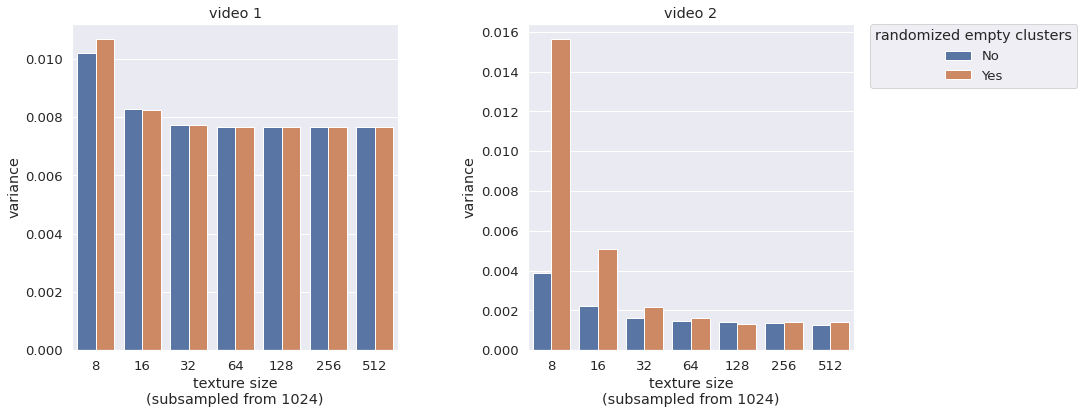

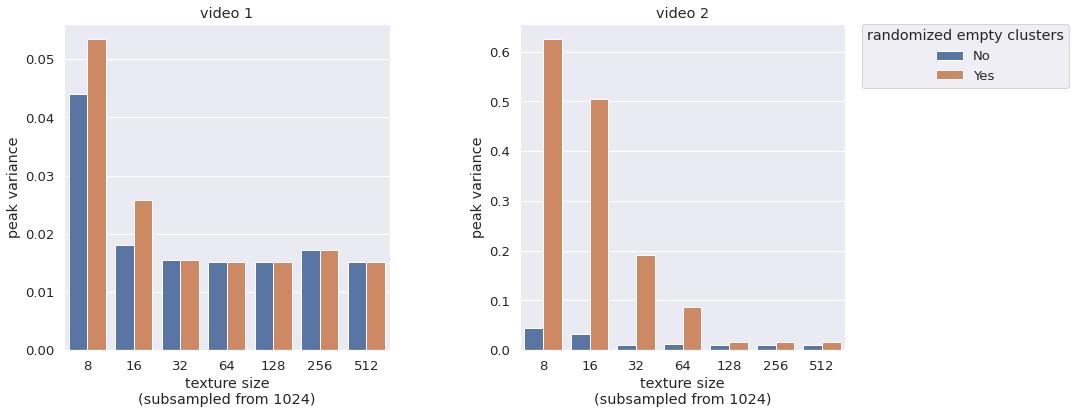

In [14]:
display(Markdown("## Plots"))

def randomized_empty_clusters_plots():

    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    measurement['settings']['randomize empty clusters'],
                )
                    for measurement in M5
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "randomized empty clusters"]
        )
    
    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    def randomized_empty_clusters_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["total variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["total variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    def randomized_empty_clusters_peak_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    randomized_empty_clusters_variance_plots()
    randomized_empty_clusters_peak_variance_plots()

randomized_empty_clusters_plots()

In [15]:
display(Markdown('# Dataset 6: KHM and random swap'))

M6 = load_measurements("6. KHM and random swap")

M6 = sorted(
    M6,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        int(measurement["settings"]["number of iterations"]),
        measurement["settings"]["random swap"],
        measurement["settings"]["KHM"],
    )
)

show_measurements_table(M6)

# Dataset 6: KHM and random swap

number of iterations  |  video file  |  random swap  |  KHM  |  variance
------------------------------------------------------------------------
3                     |  1           |  No           |  No   |  0.00764   
3                     |  1           |  No           |  Yes  |  0.00767   
3                     |  1           |  Yes          |  No   |  0.00764   
5                     |  1           |  No           |  No   |  0.00761   
5                     |  1           |  No           |  Yes  |  0.00765   
5                     |  1           |  Yes          |  No   |  0.00761   
7                     |  1           |  No           |  No   |  0.00760   
7                     |  1           |  No           |  Yes  |  0.00764   
7                     |  1           |  Yes          |  No   |  0.00760   
9                     |  1           |  No           |  No   |  0.00759   
9                     |  1           |  No           |  Yes  |  0.00766   
9                     |  1   

## Plots

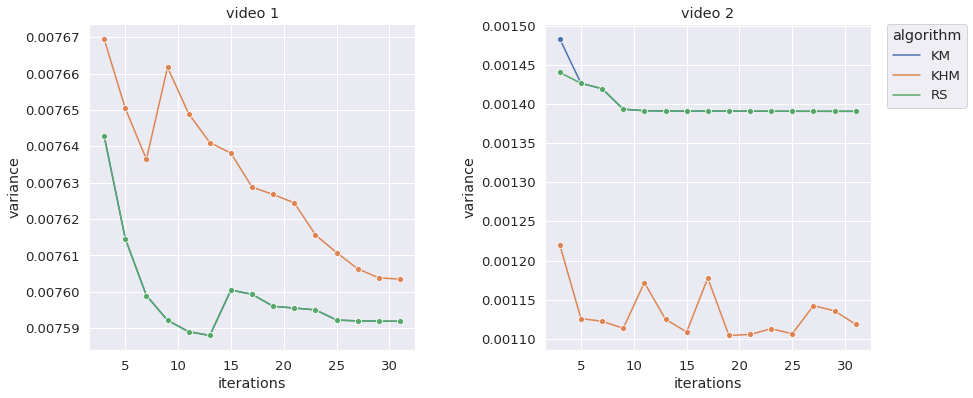

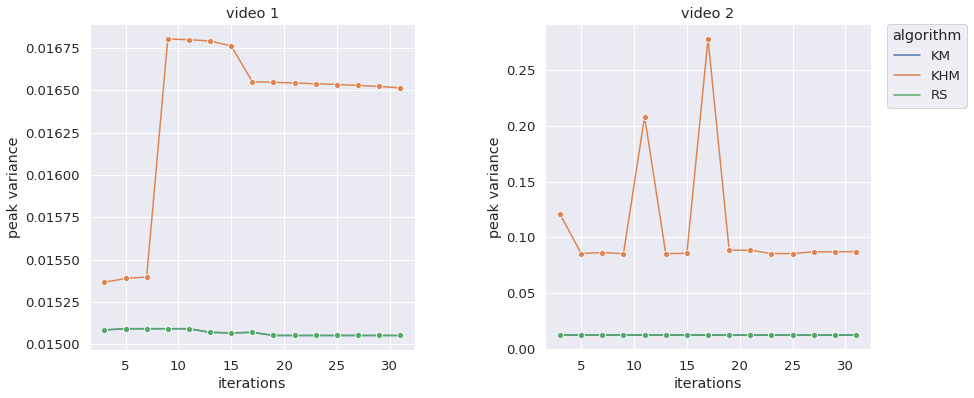


KM overlaps with RS<br>
=> this tells us, that KM never got stuck in a local minimum

## Explanation

KHM converges slower than KM on good initializations.
In this case initialization is good, as demonstrated by RS aligning with KM.

If the initialization was bad, RS would eventually find a better solution than KM.

Slower convergence of KHM causes higher peaks (maybe?).

## Trade-off
* RS and KM have reliably lower peaks than KHM
* KHM is resistant against local minimum with a single iteration
* KM did not get stuck in a local minimum a single time

KHM was implemented with $p=3$ because integer exponent can be optimized by replacing exponentiation with multiplication.
        

In [16]:
display(Markdown("## Plots"))

def modes_plot():
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    "KHM" if  measurement['settings']['KHM'] == "Yes"
                        else
                            "RS" if measurement['settings']['random swap'] == "Yes"
                        else
                            "KM",
                    measurement['total variance'], # + (0.00001 if measurement['settings']['random swap'] == "Yes" else 0),
                    measurement['peak variance'],
                    int(measurement['settings']['number of iterations']),
                )
                    for measurement in measurements
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["mode", "total variance", "peak variance", "number of iterations"]
        )

    data = {
        f"video {video}" : load_video(video, M6)
            for video in ["1", "2"]
    }
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["mode"],
            ax=axes[0],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["mode"],
            ax=axes[1],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["mode"],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["mode"],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()
    
modes_plot()

display(
    Markdown(
        """
KM overlaps with RS<br>
=> this tells us, that KM never got stuck in a local minimum

## Explanation

KHM converges slower than KM on good initializations.
In this case initialization is good, as demonstrated by RS aligning with KM.

If the initialization was bad, RS would eventually find a better solution than KM.

Slower convergence of KHM causes higher peaks (maybe?).

## Trade-off
* RS and KM have reliably lower peaks than KHM
* KHM is resistant against local minimum with a single iteration
* KM did not get stuck in a local minimum a single time

KHM was implemented with $p=3$ because integer exponent can be optimized by replacing exponentiation with multiplication.
        """
    )
)

In [17]:
display(
    Markdown(
"""
# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.
"""
    )
)


# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.


In [18]:
display(Markdown('# ETC'))

# ETC

In [19]:
display(Markdown('## KHM(p)'))

def show_KHM_p_measurement(p):
    Mp = load_measurements(f"KHM(p)/{p}")

    Mp = sorted(
        Mp,
        key = lambda measurement: (
            int(measurement["settings"]["video file"]),
        )
    )
    
    show_measurements_table(Mp)
    print("\n")

show_KHM_p_measurement("2.0")
show_KHM_p_measurement("3.0")
show_KHM_p_measurement("3.5")

## KHM(p)

video file  |  variance
-----------------------
1           |  0.00792   
2           |  0.00146   


video file  |  variance
-----------------------
1           |  0.00767   
2           |  0.00122   


video file  |  variance
-----------------------
1           |  0.00850   
2           |  0.00902   




## Per-frame KM vs KHM

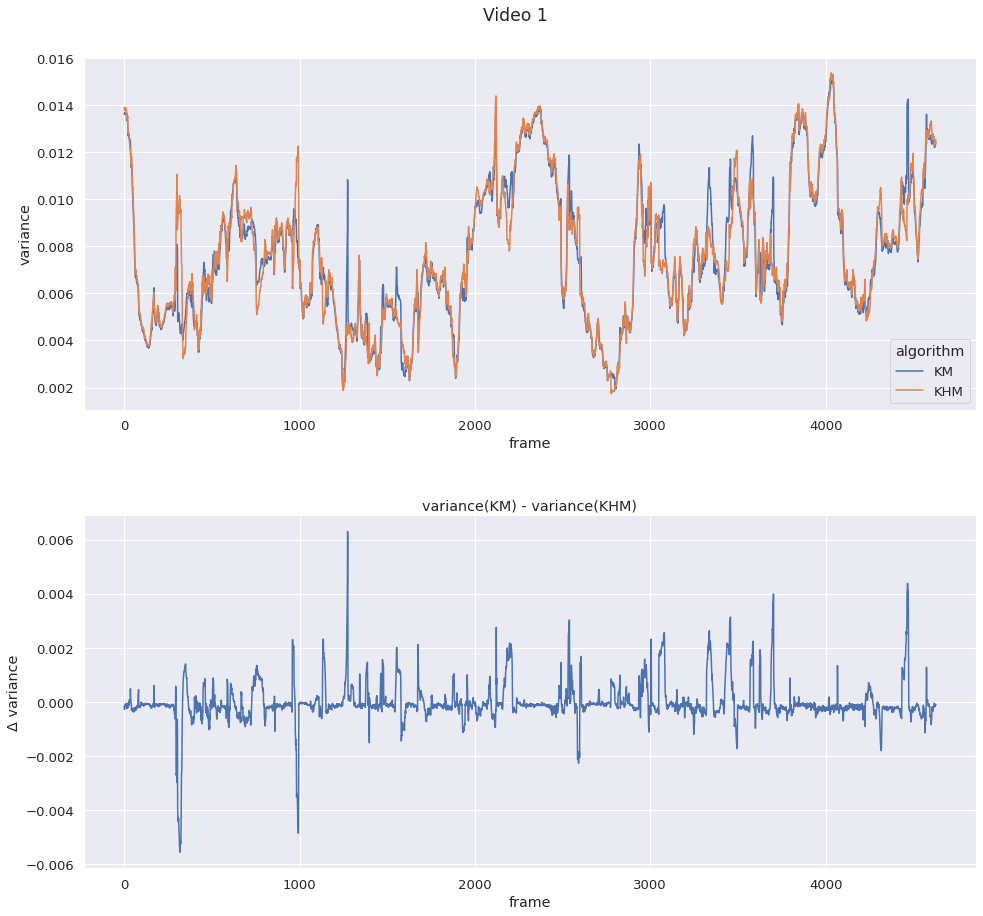

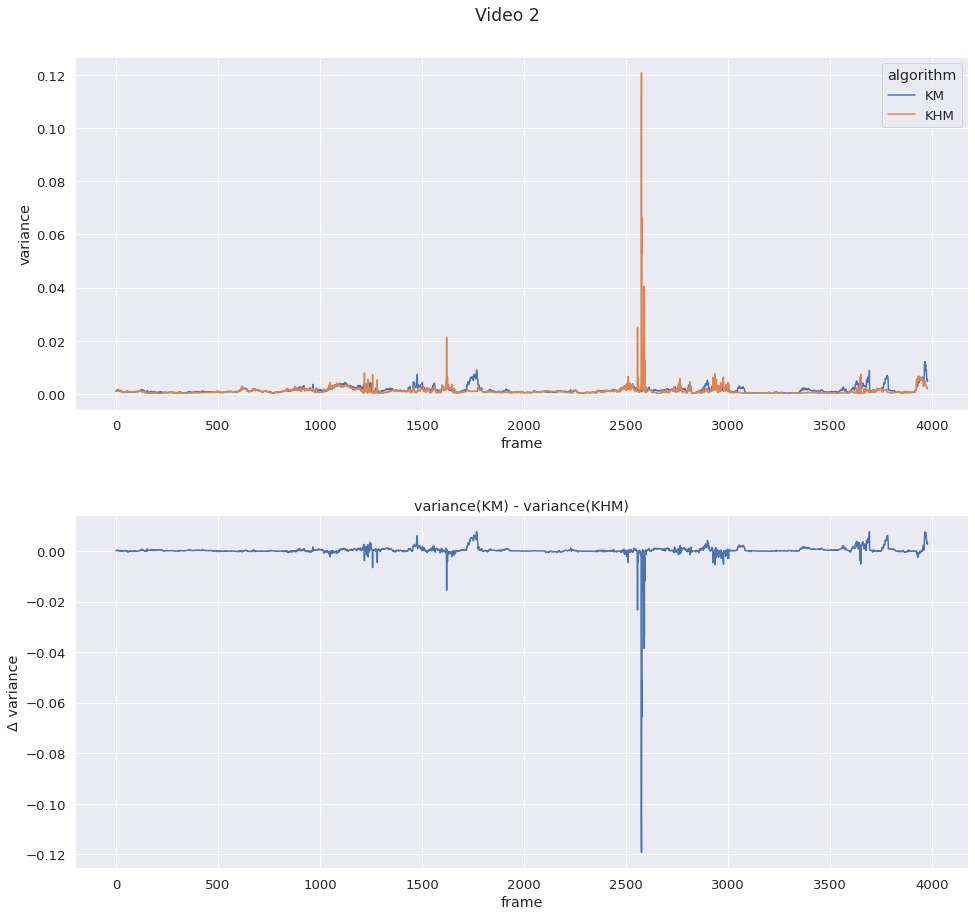

In [20]:
display(Markdown('## Per-frame KM vs KHM'))

def plot_per_frame(video):
    data = pd.DataFrame(
        [
            line
            for measurement_data in [
                list(
                    zip(
                        [algorithm for i in range(len(variances))],
                        [i for i in range(len(variances))],
                        variances
                    )
                )
                for algorithm, variances in [
                    (
                        "KHM" if measurement['settings']["KHM"] == "Yes"
                            else "KM",
                        measurement["variance"]
                    )
                    for measurement in M6
                        if measurement['settings']['number of iterations'] == "3"
                            and measurement['settings']['video file'] == video
                            and (
                                measurement['settings']["KHM"] == "Yes"
                                or measurement['settings']["random swap"] == "No"
                            )
                ]
            ]
            for line in measurement_data
        ],
        columns=["algorithm", "frame", "variance"]
    )
    
    fig, ax = plt.subplots(2,1, figsize=(16,14))
    
    sb.lineplot(
        x=data["frame"],
        y=data["variance"],
        hue=data["algorithm"],
        ci=None,
        ax=ax[0]
    )
    
    #ax[0].set_title("per-frame variance")
    
    data_km = data[data["algorithm"].isin(["KM"])].reset_index()
    data_khm = data[data["algorithm"].isin(["KHM"])].reset_index()
    
    data_diff = data_km.copy()
    del data_diff["algorithm"]
    data_diff["variance"] = [
        data_km.loc[i, "variance"] - data_khm.loc[i, "variance"]
        for i in range(len(data_km["variance"]))
    ]
    
    sb.lineplot(
        x=data_diff["frame"],
        y=data_diff["variance"],
        ci=None,
        ax=ax[1]
    )
    
    ax[1].set_title("variance(KM) - variance(KHM)")
    ax[1].set_ylabel("Δ variance")
    
    fig.suptitle(f"Video {video}")
    
    plt.subplots_adjust(
        hspace=0.3,
        top=0.93
    )
    
    plt.show()
        
plot_per_frame("1")
plot_per_frame("2")

## Alternate KM-KHM

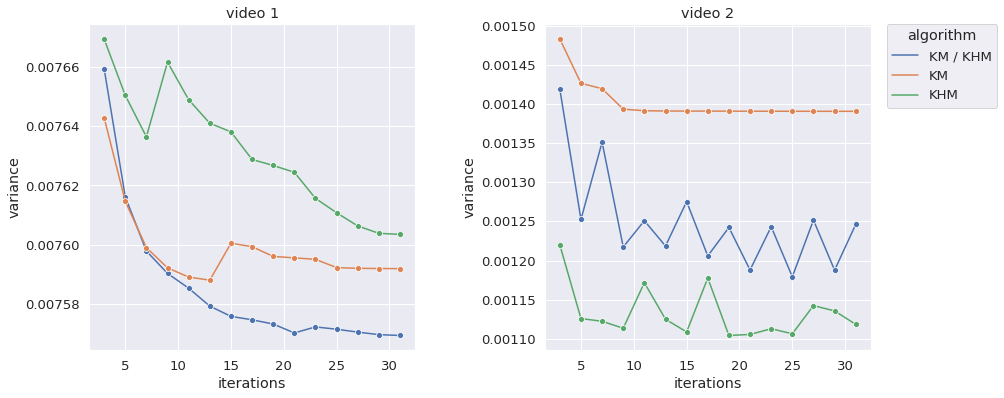

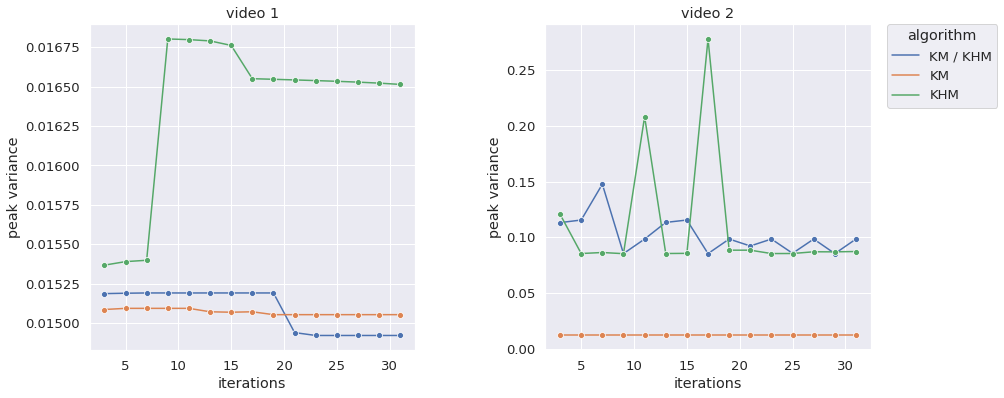


### Compromise

KHM / KM should be enough to avoid local optimum, while reducing downsides of KHM
* slow convergence
* higher peak (mostly due to slow convergence)
        

In [21]:
display(Markdown("## Alternate KM-KHM"))


M_alternate = load_measurements("Alternate KM-KHM")

def plot_alternate():

    def load_video(video_name, measurements):
            return pd.DataFrame(
                [
                    (
                        "KM / KHM",
                        measurement['total variance'], # + (0.00001 if measurement['settings']['random swap'] == "Yes" else 0),
                        measurement['peak variance'],
                        int(measurement['settings']['number of iterations']),
                    )
                        for measurement in measurements
                            if measurement['settings']["video file"] == video_name
                ],
                columns=["mode", "total variance", "peak variance", "number of iterations"]
            )

    data = {
        f"video {video}" : load_video(video, M_alternate)
            for video in ["1", "2"]
    }

    for video in data:
        data[video] = pd.concat(
            [
                data[video],
                pd.DataFrame(
                    [
                        (
                            "KHM" if  measurement['settings']['KHM'] == "Yes"
                                    else
                                        "RS" if measurement['settings']['random swap'] == "Yes"
                                    else
                                        "KM",
                            measurement['total variance'],
                            measurement['peak variance'],
                            int(measurement['settings']['number of iterations']),
                        )
                            for measurement in M6
                                if measurement['settings']["video file"] == video.split(" ")[-1]
                                and measurement['settings']['random swap'] == "No"
                    ],
                    columns=["mode", "total variance", "peak variance", "number of iterations"]
                )
            ]
        ).reset_index()
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["mode"],
            ax=axes[0],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["mode"],
            ax=axes[1],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["mode"],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["mode"],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()

plot_alternate()

display(
    Markdown(
        """
### Compromise

KHM / KM should be enough to avoid local optimum, while reducing downsides of KHM
* slow convergence
* higher peak (mostly due to slow convergence)
        """
    )    
)

In [22]:
display(
    Markdown(
        """
### Thoughts

Look at random swap paper to see which prameters affect KM positively and negatively.

* First video has more color variation (overlap), which was observed to improve KM performance.
        """
    )    
)


### Thoughts

Look at random swap paper to see which prameters affect KM positively and negatively.

* First video has more color variation (overlap), which was observed to improve KM performance.
        

In [23]:
display(
    Markdown(
"""
# Overview

Skim through clustering overview papers once again
"""
    )
)


# Overview

Skim through clustering overview papers once again


In [24]:
display(
    Markdown(
"""
# Future work

* check if alternating KM/KHM can still get out of local optimum like KHM ([datasets](http://cs.joensuu.fi/sipu/datasets/))
"""
    )
)


# Future work

* check if alternating KM/KHM can still get out of local optimum like KHM ([datasets](http://cs.joensuu.fi/sipu/datasets/))


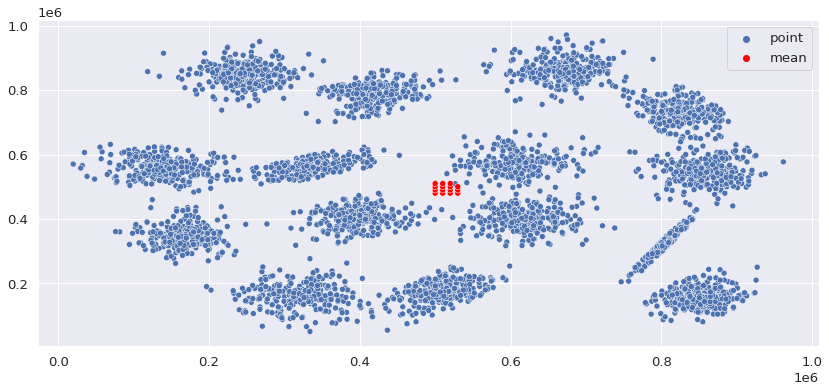

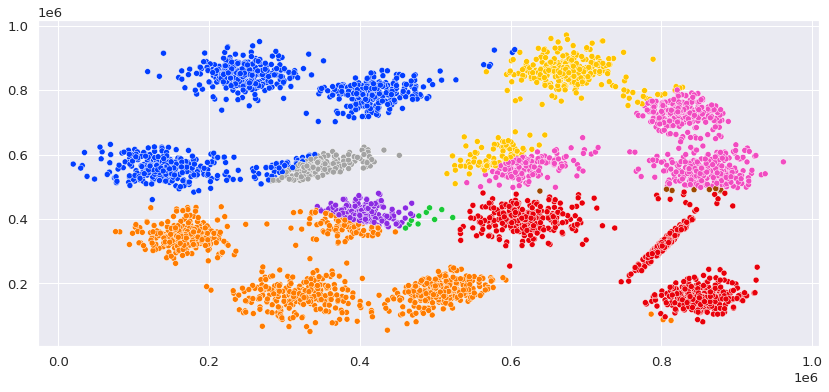

In [117]:
def verify_alternating():
    num_clusters = 15
    
    with open("Datasets/S/S1.txt") as file:
        points = [
           filter(
                lambda x: x != '',
                line.split(" ")
            )
            for line in file.readlines()
        ]
        points = [
            tuple([int(coord.replace("/n", "")) for coord in point])
            for point in points
        ]
        
        points = list(zip(*points))
        
        attribution = [0] * len(points[0])
        means = [
            (500000 + (i % 4)*10000, 500000 + (i // 4 - 2)*10000) for i in range(15)
        ]
        means = [list(col) for col in list(zip(*means))]
        
        def km():
            attribution = [0] * len(points)
            for point in points:
                pass
        
        sb.scatterplot(
            x=points[0],
            y=points[1],
            hue=["point"] * len(points[0])
        )

        sb.scatterplot(
            x=means[0],
            y=means[1],
            hue=["mean"] * len(means[0]),
            palette=["red"]
        )

        plt.show()
            
        def cluster_iteration():
            def km_distance(point, mean_index):
                def pow2(x):
                    return x*x
                
                dist = 0
                mean = list(zip(*means))[mean_index]
                for i, coord in enumerate(mean):
                    dist += pow2(point[i] - coord)
                return math.sqrt(dist)
            
            for point_index, (x,y) in enumerate(zip(*points)):
                distances = [
                    km_distance((x,y), mean_index)
                    for mean_index in range(len(means[0]))
                ]
                for mean_index, distace in enumerate(distances):
                    if distances[mean_index] == min(distances):
                        attribution[point_index] = mean_index
            
            for cluster_index in range(len(means)):
                relevant_points = [
                    point
                    for point_index, point in enumerate(zip(*points))
                        if attribution[point_index] == cluster_index
                ]
                relevant_points = list(zip(*relevant_points))
                for coord_index in range(len(means)):
                    means[cluster_index][coord_index] = sum(relevant_points[coord_index]) / len(relevant_points[coord_index])
        
        for i in range(20):
            cluster_iteration()
        
        sb.scatterplot(
            x=points[0],
            y=points[1],
            hue=attribution,
            palette="bright"
        ).legend().remove()
        
        plt.show()
    
    
verify_alternating()